## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [661]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [662]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

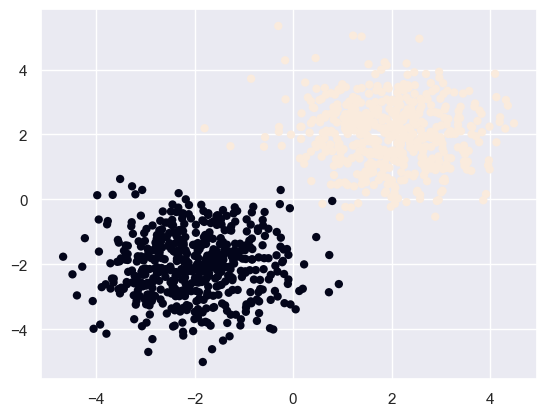

In [663]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [664]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()

# print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [665]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [666]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

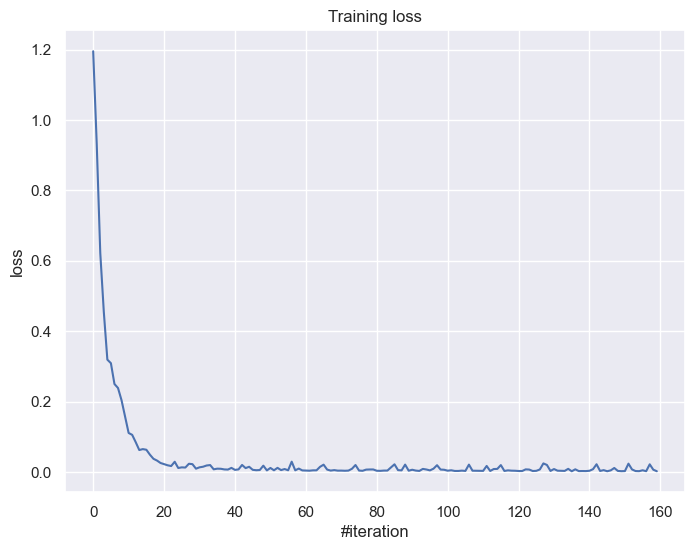

Current loss: 0.002221


In [667]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [668]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

File 'mnist.py' already there; not retrieving.



In [669]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [866]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

import seaborn as sns

import time

sns.set(style='darkgrid')

mps_device = torch.device("mps")

In [671]:
X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

encoder = OneHotEncoder(categories='auto', sparse_output=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))


In [672]:
X_train, X_val, X_test = list(map(lambda x: x.reshape((x.shape[0], -1)), [X_train, X_val, X_test]))

In [673]:
X_train.shape

(50000, 784)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [674]:
# Your code goes here. ################################################
def build_net(activation_fn, batch_normalization=False):
    net = Sequential()
    net.add(Linear(784, 128))
    if batch_normalization:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(128))
    net.add(activation_fn())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

def update_optimizer():
    global optimizer_config, optimizer_state
    optimizer_config = {'learning_rate' : 3e-3, 'momentum': 0.9, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5}
    optimizer_state = {}

In [675]:
n_epoch = 20
batch_size = 128
criterion = ClassNLLCriterion()

batch_normalization_parameters = [False, True]
activation_functions = [ReLU, ELU, LeakyReLU, SoftPlus]
optimizers = [sgd_momentum, adam_optimizer]

results = []

In [676]:
for batch_normalization_parameter in batch_normalization_parameters:
    for activation_function in activation_functions:
        for optimizer in optimizers:
            
            print(batch_normalization_parameter, activation_function.__name__, optimizer.__name__)

            update_optimizer()
            net = build_net(activation_function, batch_normalization=batch_normalization_parameter)


            loss_history = []
            accuracy_history = []
            start_time = time.time()
    
            for i in range(n_epoch):
                net.train()
                for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size), position=0, leave=False):

                    net.zeroGradParameters()
                    
                    predictions = net.forward(x_batch)
                    loss = criterion.forward(predictions, y_batch)
                
                    dp = criterion.backward(predictions, y_batch)
                    net.backward(x_batch, dp)
                    
                    optimizer(net.getParameters(), 
                                 net.getGradParameters(), 
                                 optimizer_config,
                                 optimizer_state)      
                    
                    loss_history.append(loss)
                    
                net.evaluate()
                accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
                
            end_time = time.time()
            training_time = end_time - start_time
                
            result_entry = {
                'batch_normalization_parameter': batch_normalization_parameter,
                'activation_function': activation_function.__name__,
                'optimizer': optimizer.__name__,
                'loss_history': loss_history,
                'accuracy_history': accuracy_history,
                'training_time': training_time
            }
            results.append(result_entry)  

False ReLU sgd_momentum


False ReLU adam_optimizer


False ELU sgd_momentum


False ELU adam_optimizer


False LeakyReLU sgd_momentum


False LeakyReLU adam_optimizer


False SoftPlus sgd_momentum


False SoftPlus adam_optimizer


True ReLU sgd_momentum


True ReLU adam_optimizer


True ELU sgd_momentum


True ELU adam_optimizer


True LeakyReLU sgd_momentum


True LeakyReLU adam_optimizer


True SoftPlus sgd_momentum


True SoftPlus adam_optimizer


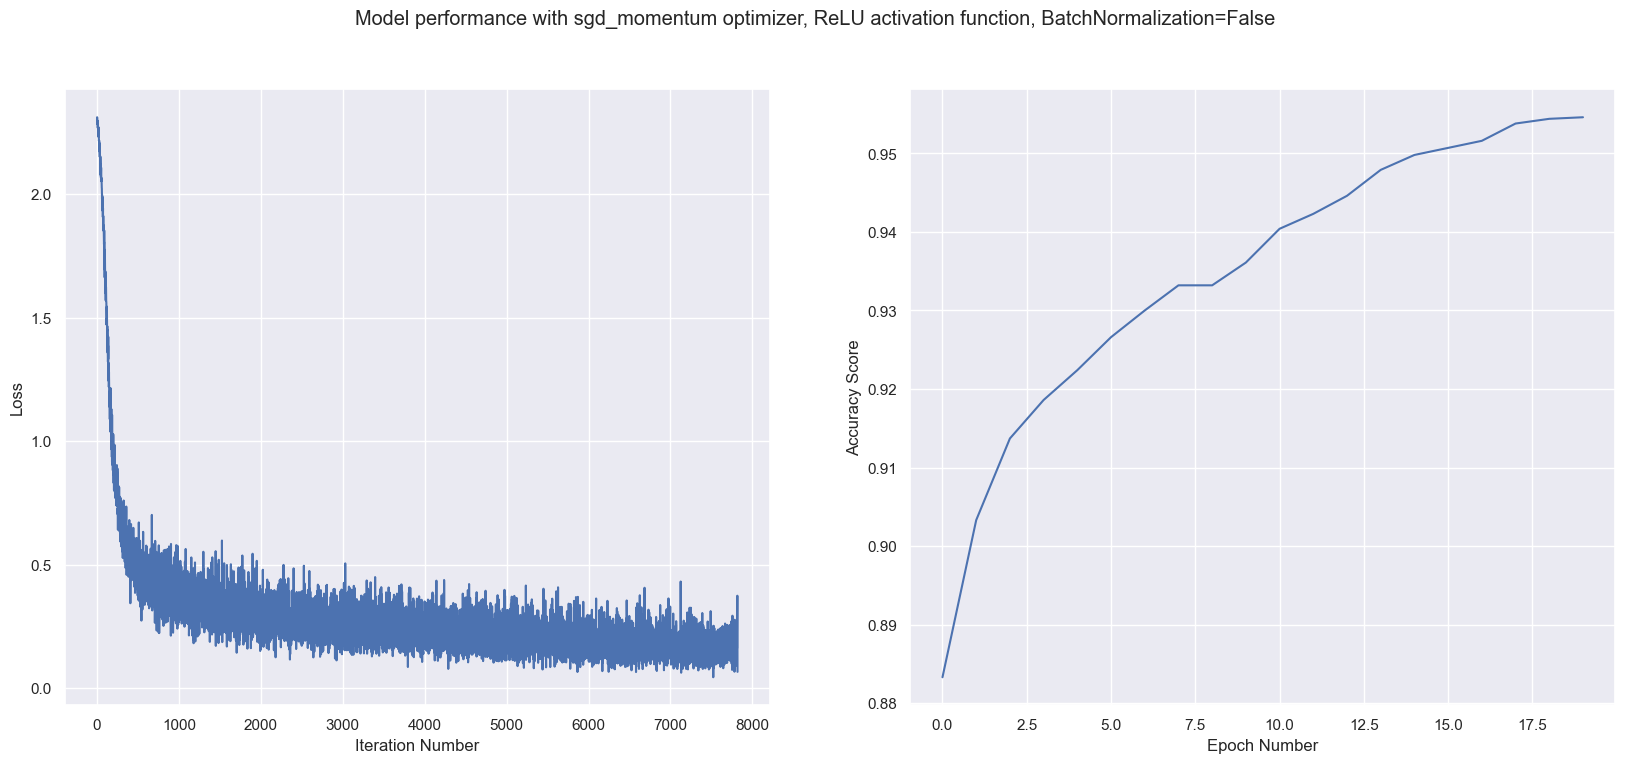

Final Loss with sgd_momentum optimizer, ReLU activation function, BatchNorm=False: 0.0652
Final Accuracy with sgd_momentum optimizer, ReLU activation function, BatchNorm=False: 0.9546
Training Time with sgd_momentum optimizer, ReLU activation function, BatchNorm=False: 175.93 seconds



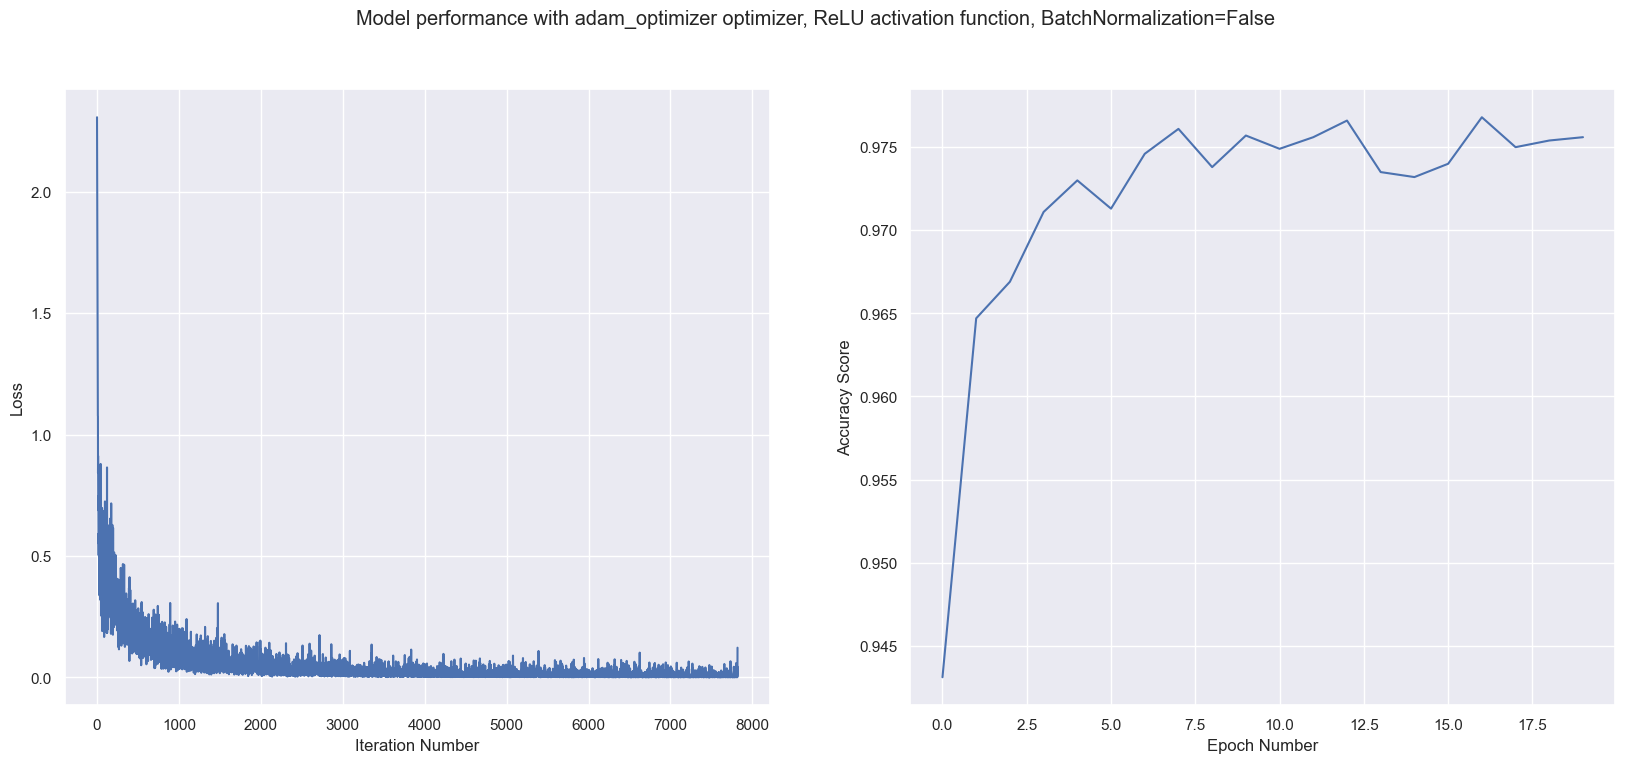

Final Loss with adam_optimizer optimizer, ReLU activation function, BatchNorm=False: 0.1218
Final Accuracy with adam_optimizer optimizer, ReLU activation function, BatchNorm=False: 0.9756
Training Time with adam_optimizer optimizer, ReLU activation function, BatchNorm=False: 175.93 seconds



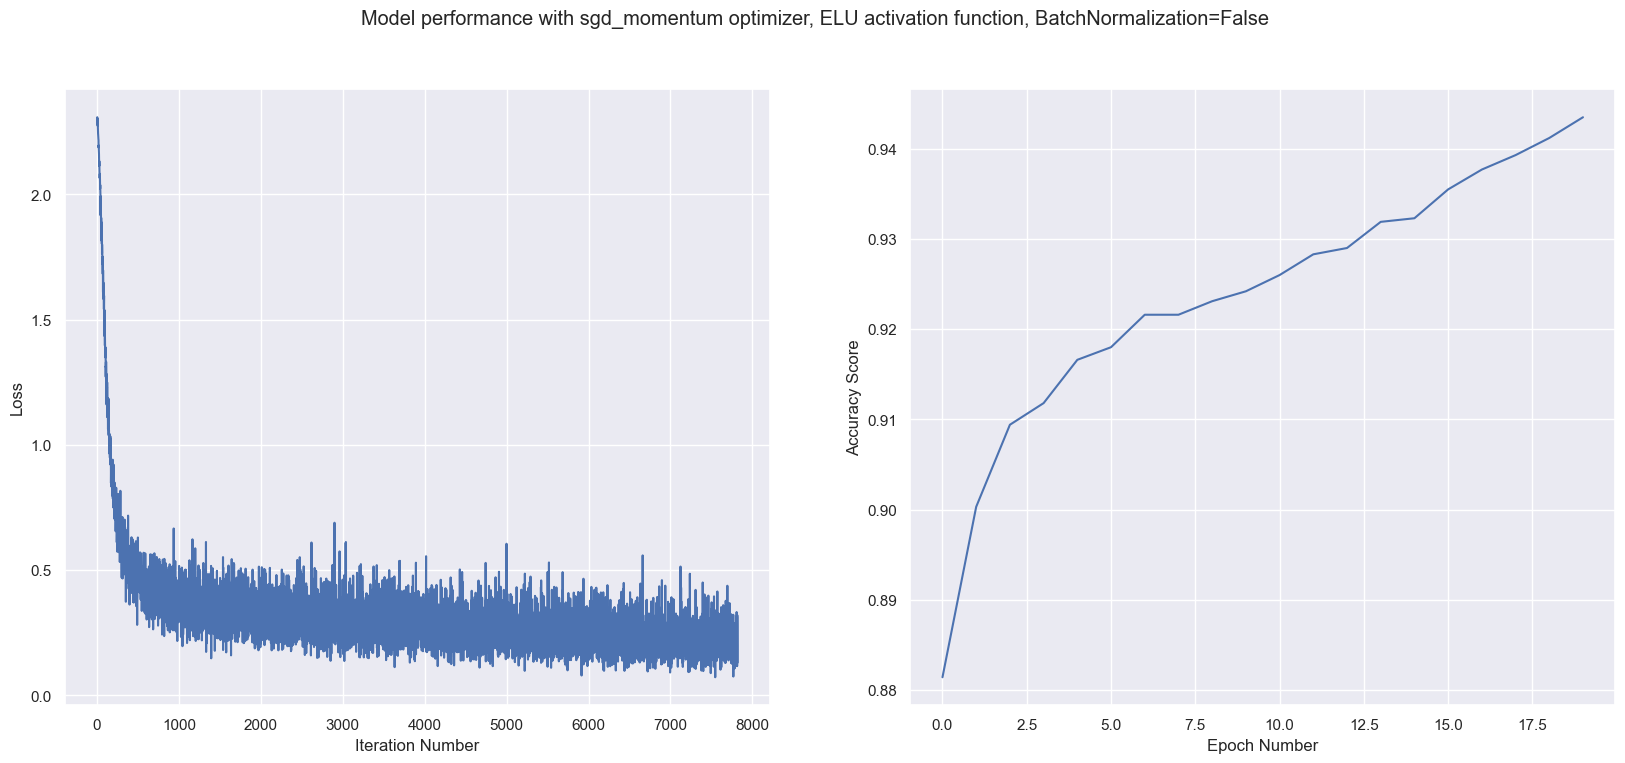

Final Loss with sgd_momentum optimizer, ELU activation function, BatchNorm=False: 0.1302
Final Accuracy with sgd_momentum optimizer, ELU activation function, BatchNorm=False: 0.9435
Training Time with sgd_momentum optimizer, ELU activation function, BatchNorm=False: 175.93 seconds



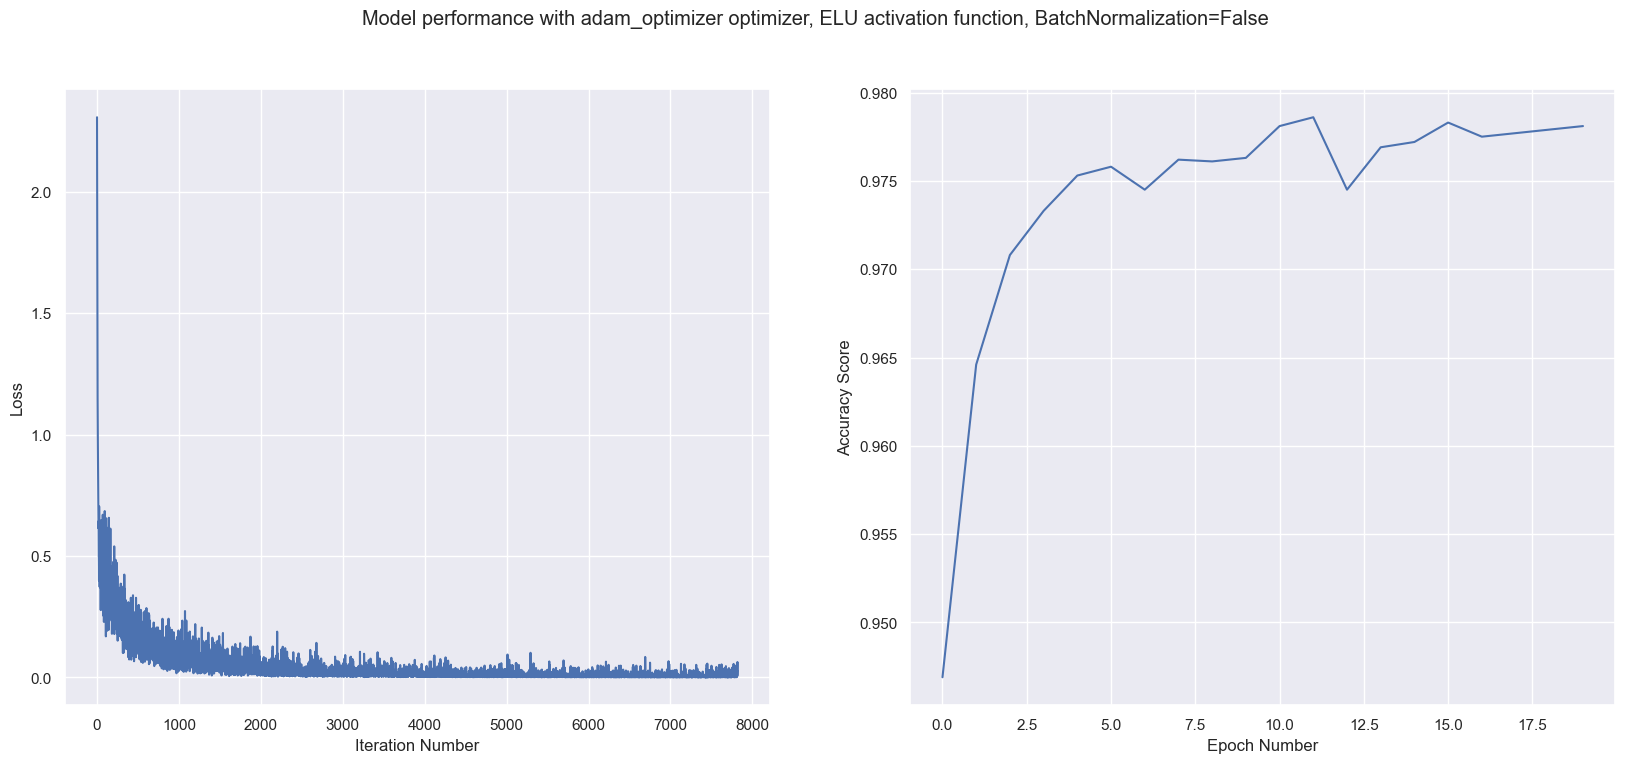

Final Loss with adam_optimizer optimizer, ELU activation function, BatchNorm=False: 0.0059
Final Accuracy with adam_optimizer optimizer, ELU activation function, BatchNorm=False: 0.9781
Training Time with adam_optimizer optimizer, ELU activation function, BatchNorm=False: 175.93 seconds



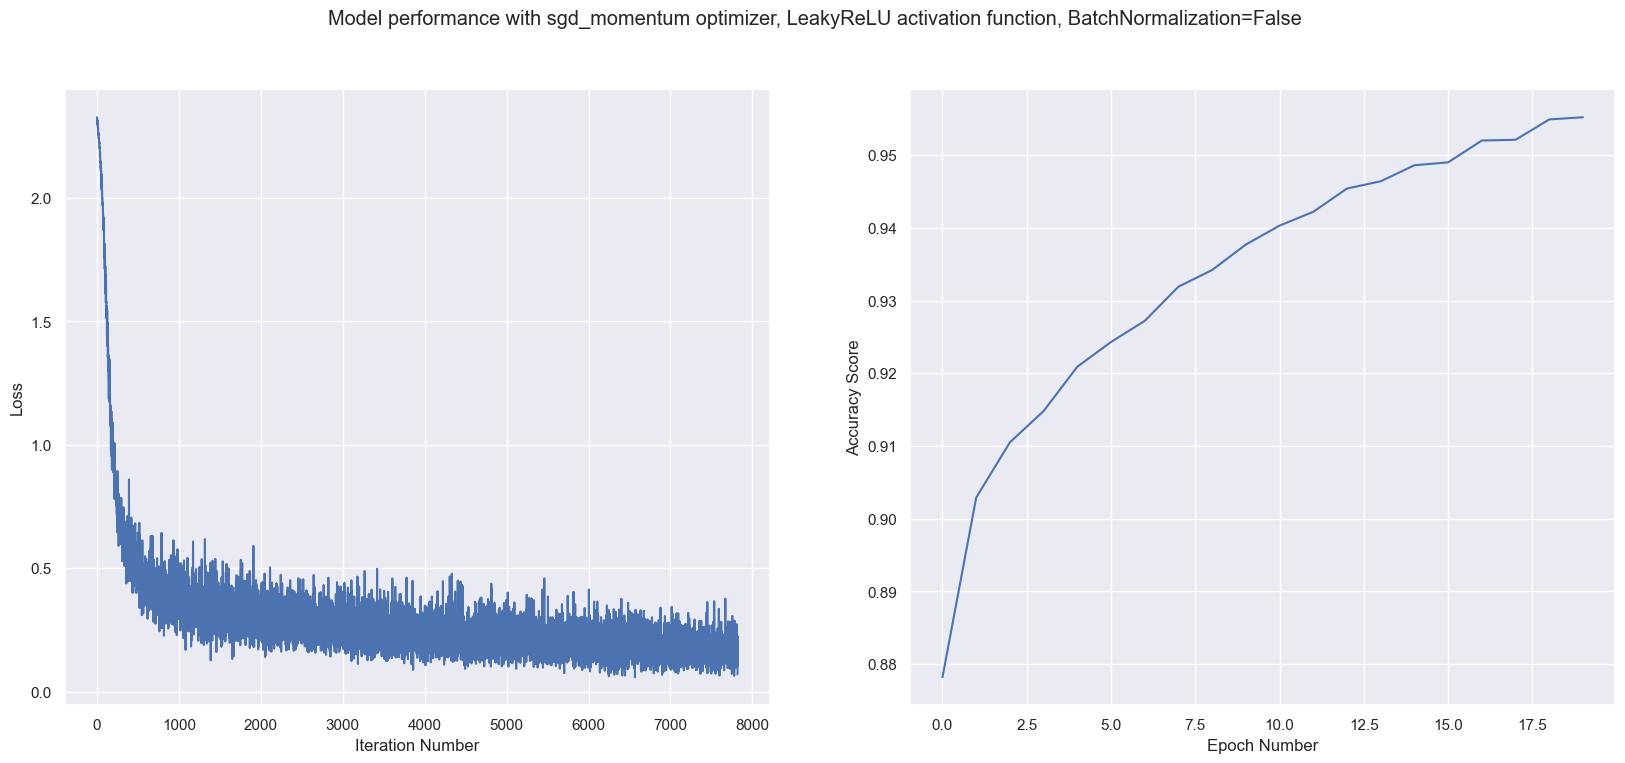

Final Loss with sgd_momentum optimizer, LeakyReLU activation function, BatchNorm=False: 0.0697
Final Accuracy with sgd_momentum optimizer, LeakyReLU activation function, BatchNorm=False: 0.9552
Training Time with sgd_momentum optimizer, LeakyReLU activation function, BatchNorm=False: 175.93 seconds



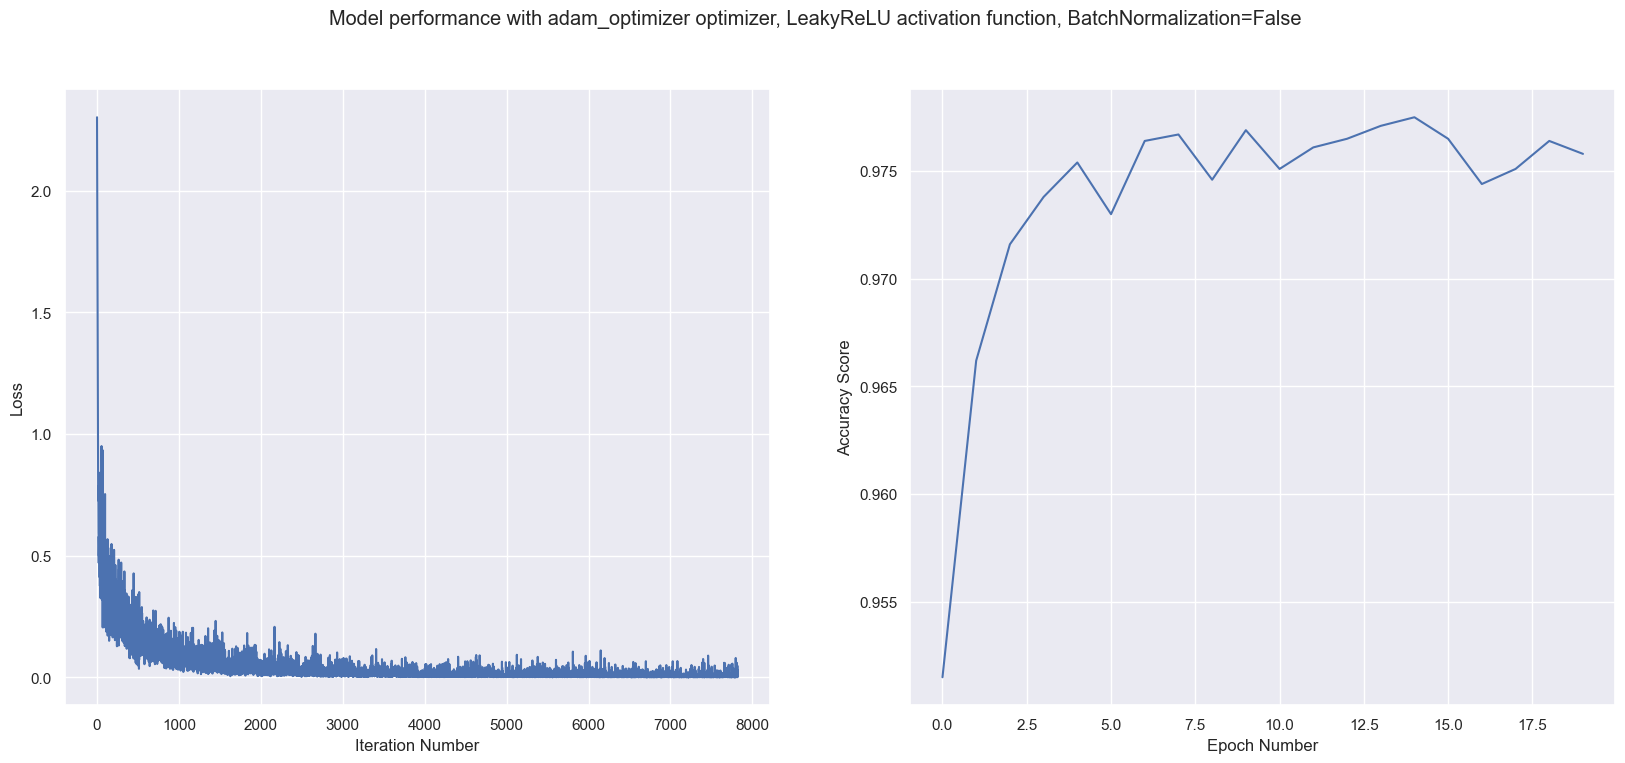

Final Loss with adam_optimizer optimizer, LeakyReLU activation function, BatchNorm=False: 0.0011
Final Accuracy with adam_optimizer optimizer, LeakyReLU activation function, BatchNorm=False: 0.9758
Training Time with adam_optimizer optimizer, LeakyReLU activation function, BatchNorm=False: 175.93 seconds



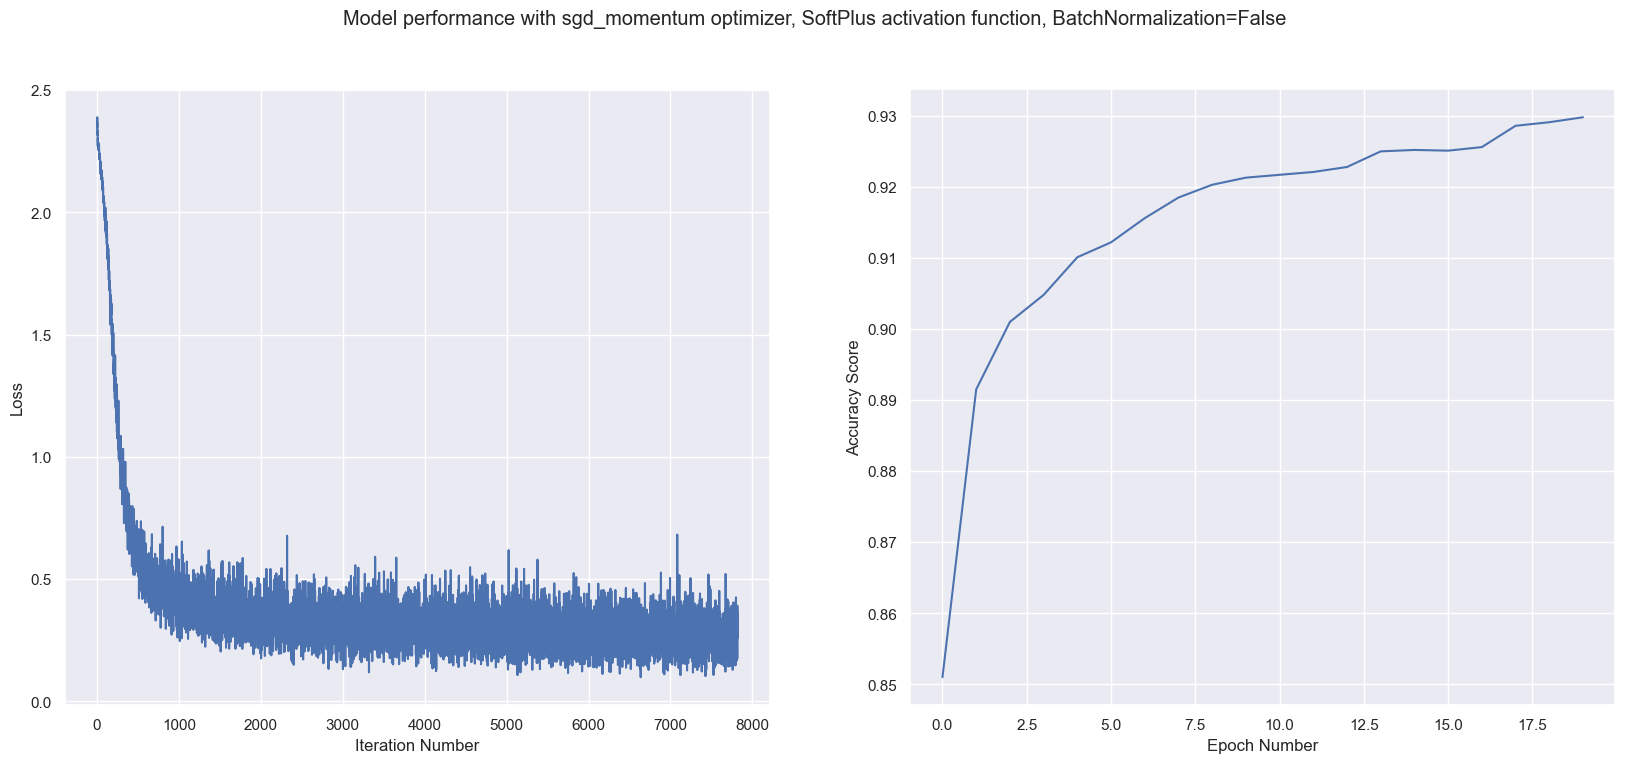

Final Loss with sgd_momentum optimizer, SoftPlus activation function, BatchNorm=False: 0.3634
Final Accuracy with sgd_momentum optimizer, SoftPlus activation function, BatchNorm=False: 0.9298
Training Time with sgd_momentum optimizer, SoftPlus activation function, BatchNorm=False: 175.93 seconds



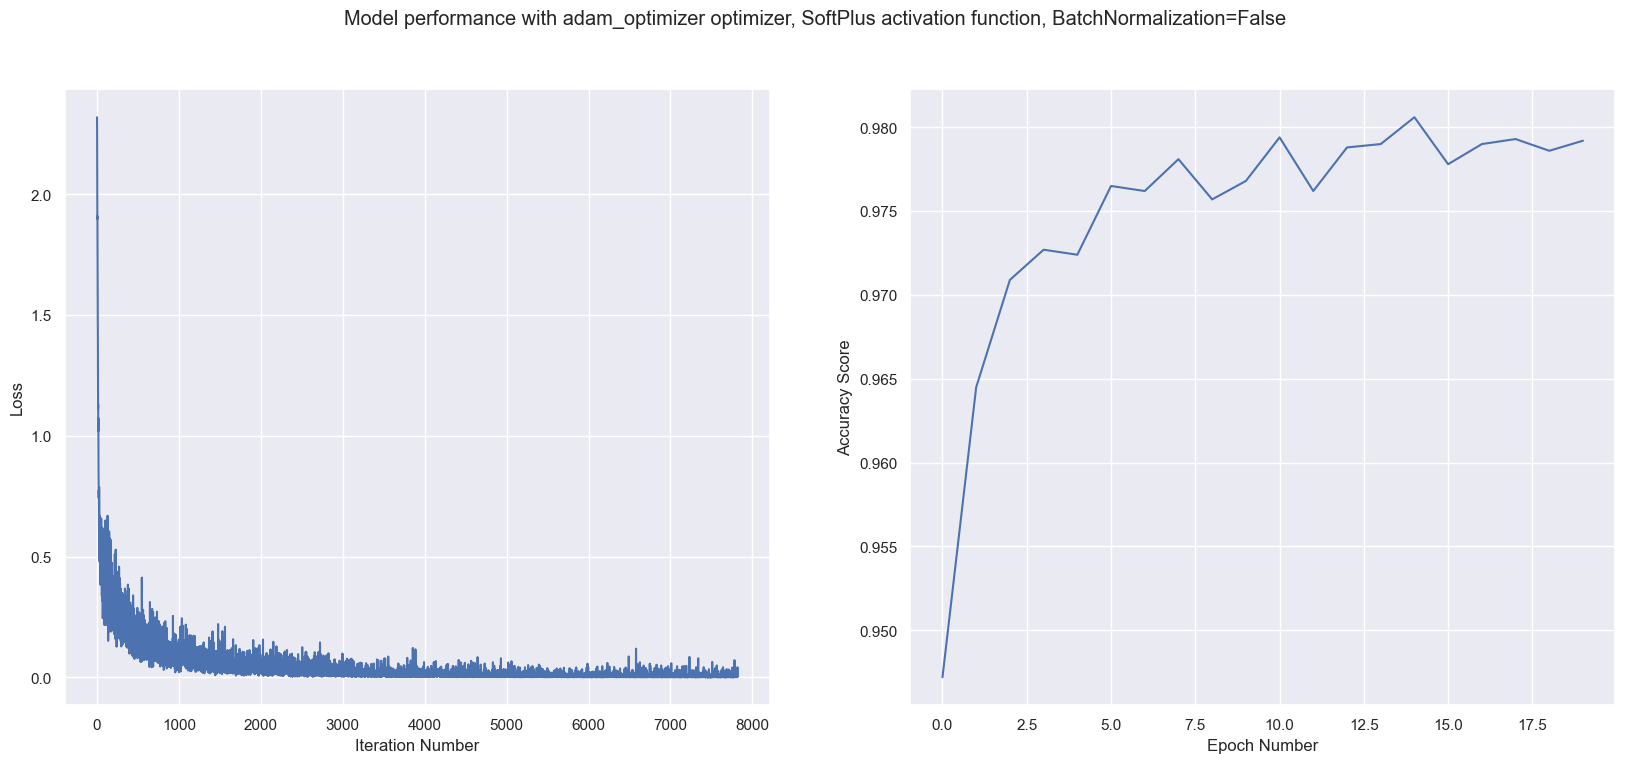

Final Loss with adam_optimizer optimizer, SoftPlus activation function, BatchNorm=False: 0.0024
Final Accuracy with adam_optimizer optimizer, SoftPlus activation function, BatchNorm=False: 0.9792
Training Time with adam_optimizer optimizer, SoftPlus activation function, BatchNorm=False: 175.93 seconds



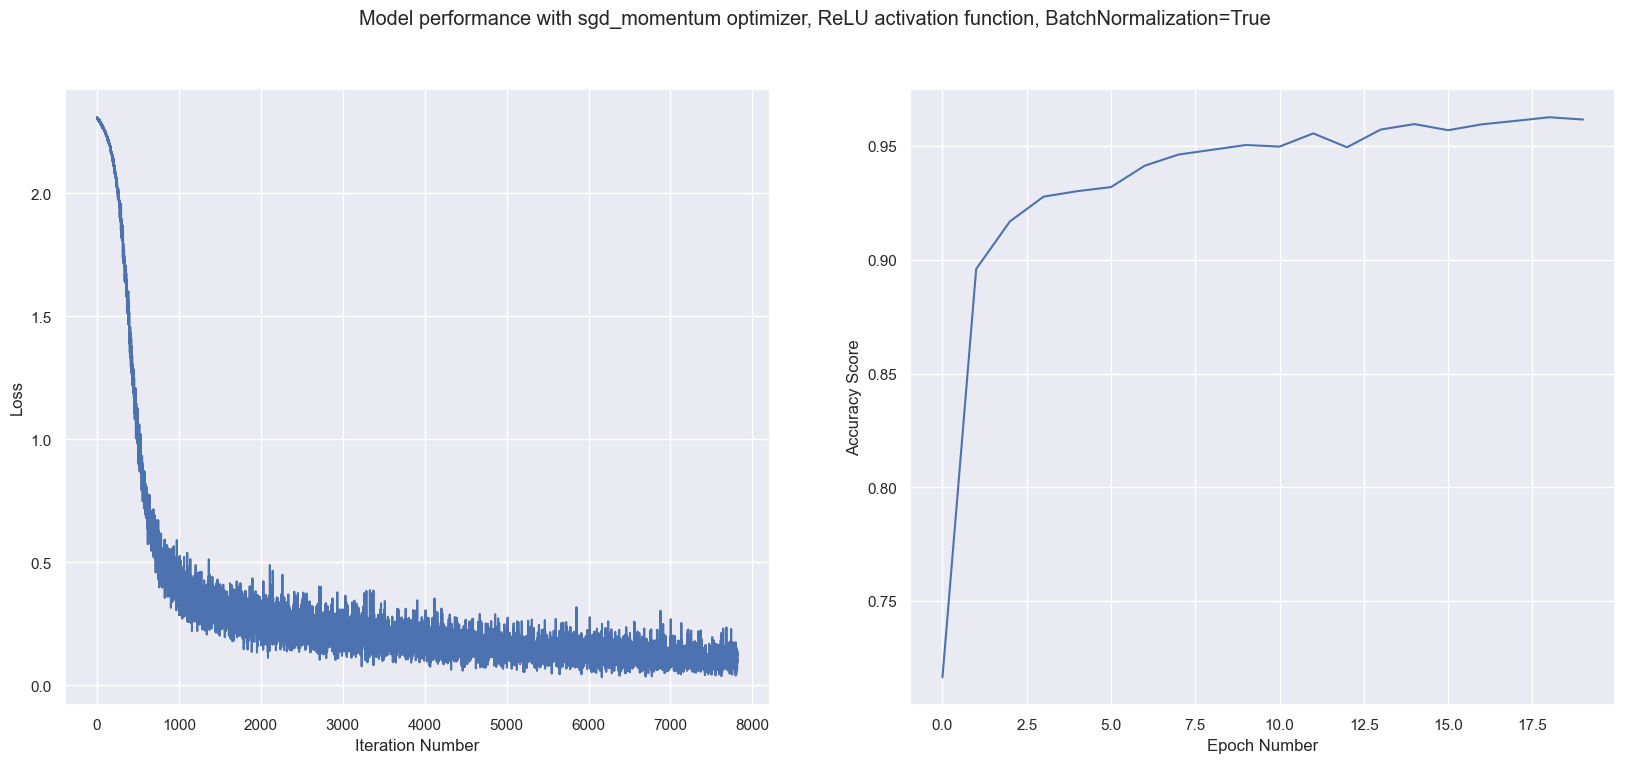

Final Loss with sgd_momentum optimizer, ReLU activation function, BatchNorm=True: 0.1203
Final Accuracy with sgd_momentum optimizer, ReLU activation function, BatchNorm=True: 0.9617
Training Time with sgd_momentum optimizer, ReLU activation function, BatchNorm=True: 175.93 seconds



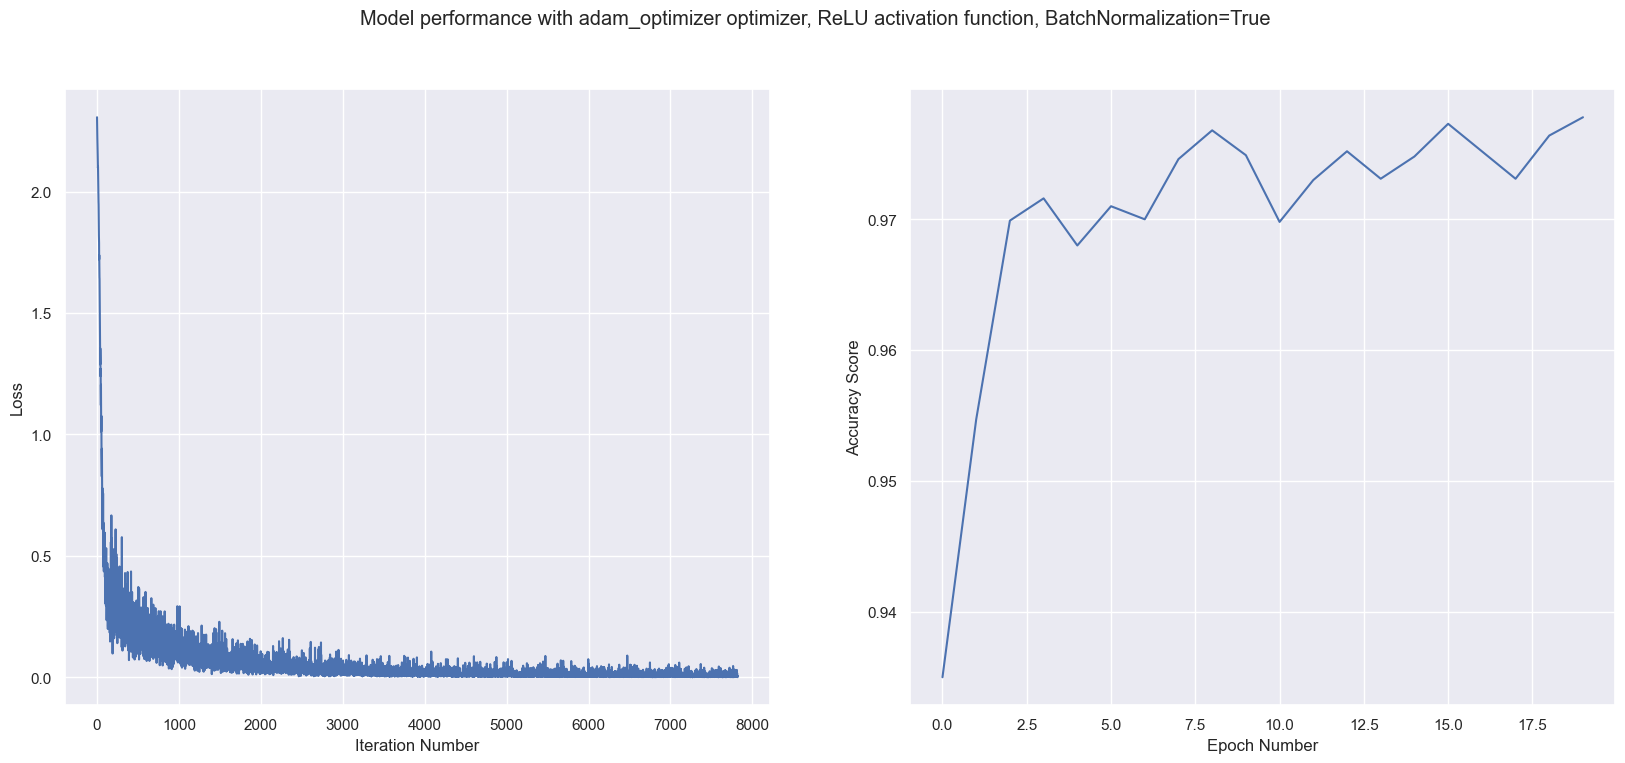

Final Loss with adam_optimizer optimizer, ReLU activation function, BatchNorm=True: 0.0025
Final Accuracy with adam_optimizer optimizer, ReLU activation function, BatchNorm=True: 0.9778
Training Time with adam_optimizer optimizer, ReLU activation function, BatchNorm=True: 175.93 seconds



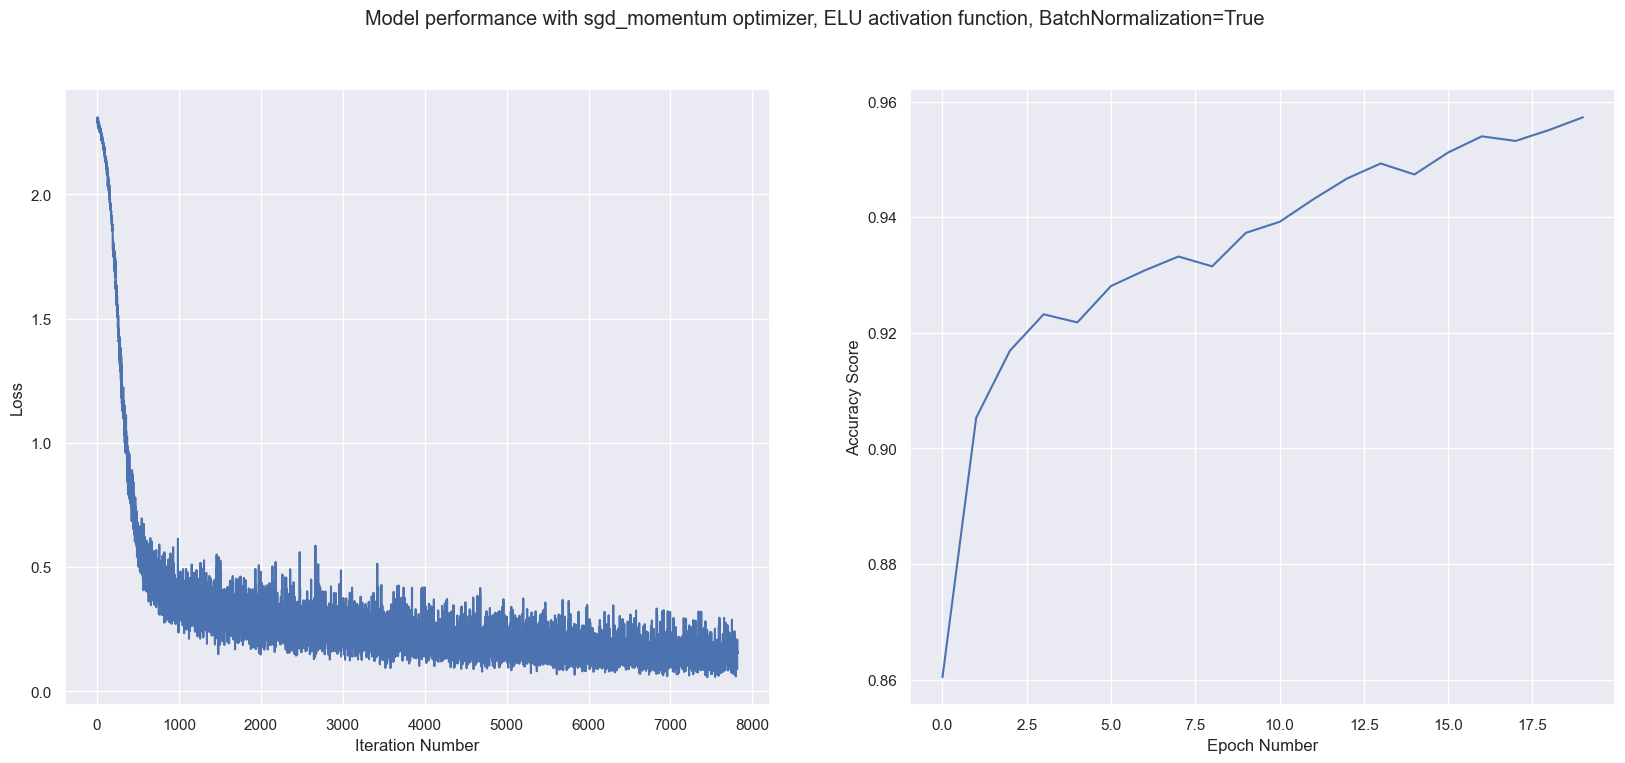

Final Loss with sgd_momentum optimizer, ELU activation function, BatchNorm=True: 0.1591
Final Accuracy with sgd_momentum optimizer, ELU activation function, BatchNorm=True: 0.9573
Training Time with sgd_momentum optimizer, ELU activation function, BatchNorm=True: 175.93 seconds



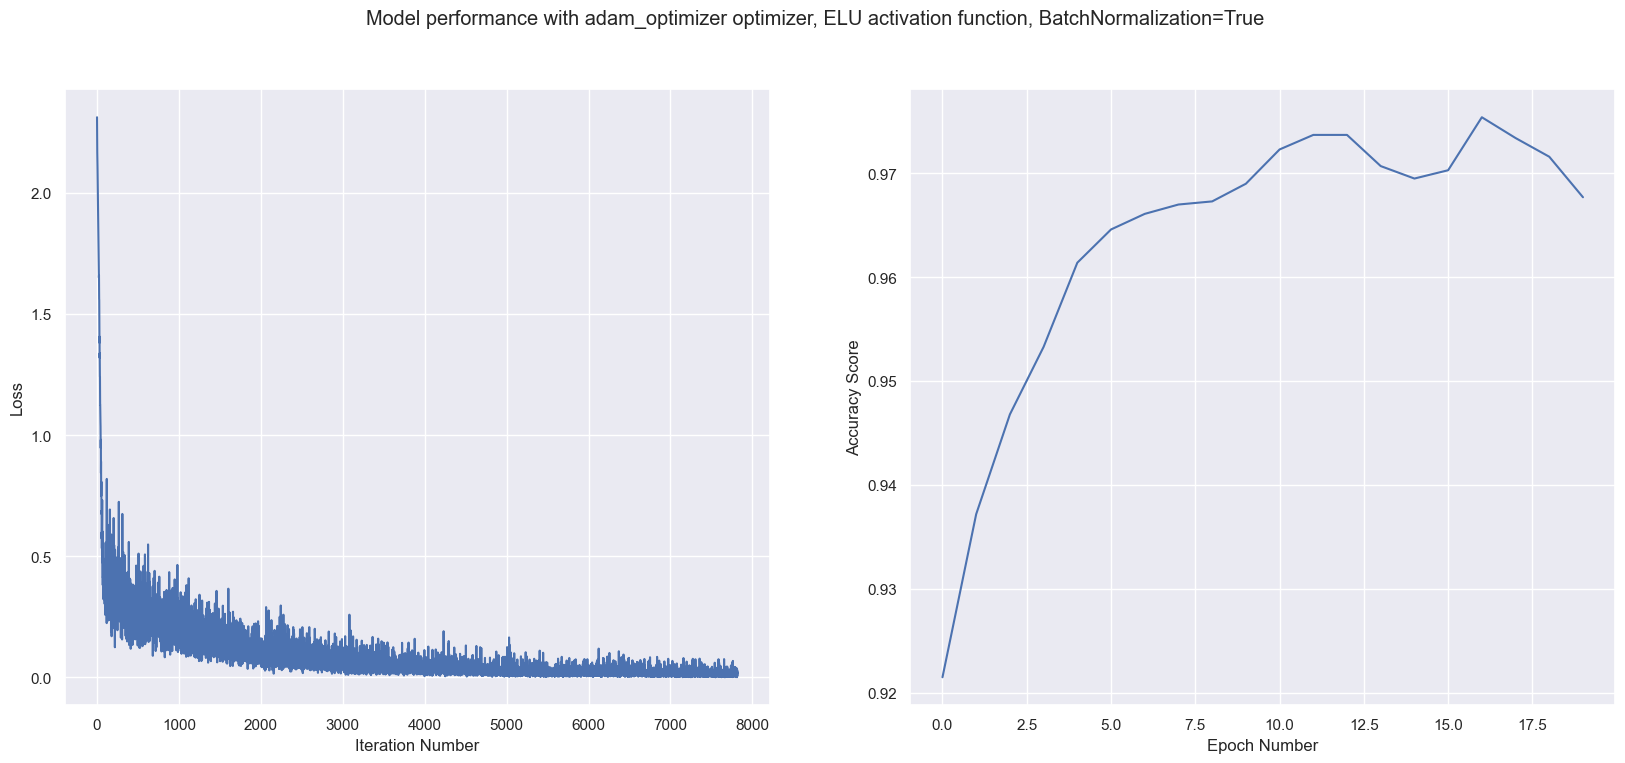

Final Loss with adam_optimizer optimizer, ELU activation function, BatchNorm=True: 0.0177
Final Accuracy with adam_optimizer optimizer, ELU activation function, BatchNorm=True: 0.9677
Training Time with adam_optimizer optimizer, ELU activation function, BatchNorm=True: 175.93 seconds



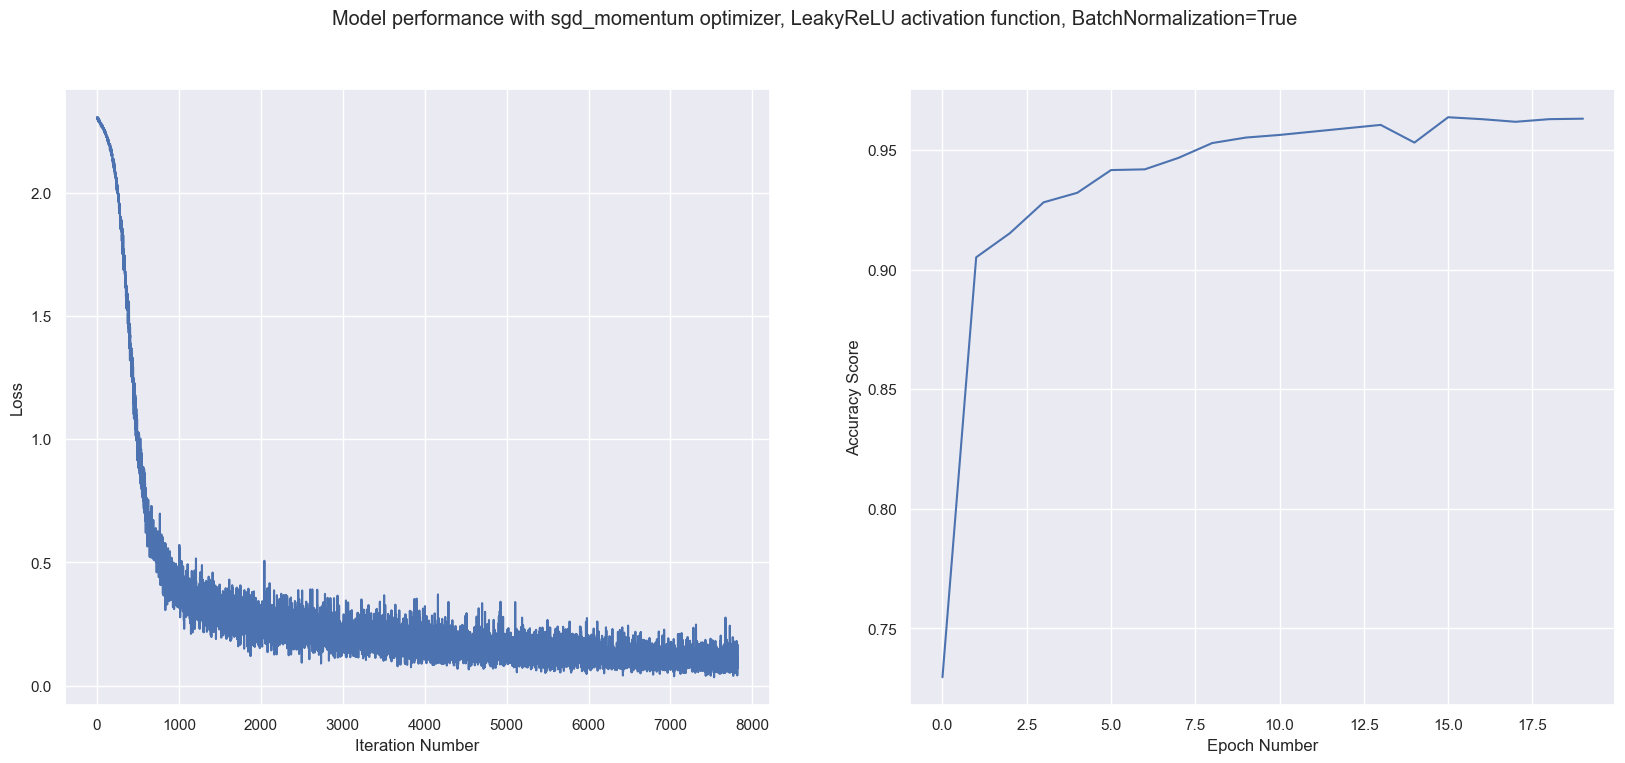

Final Loss with sgd_momentum optimizer, LeakyReLU activation function, BatchNorm=True: 0.0711
Final Accuracy with sgd_momentum optimizer, LeakyReLU activation function, BatchNorm=True: 0.9632
Training Time with sgd_momentum optimizer, LeakyReLU activation function, BatchNorm=True: 175.93 seconds



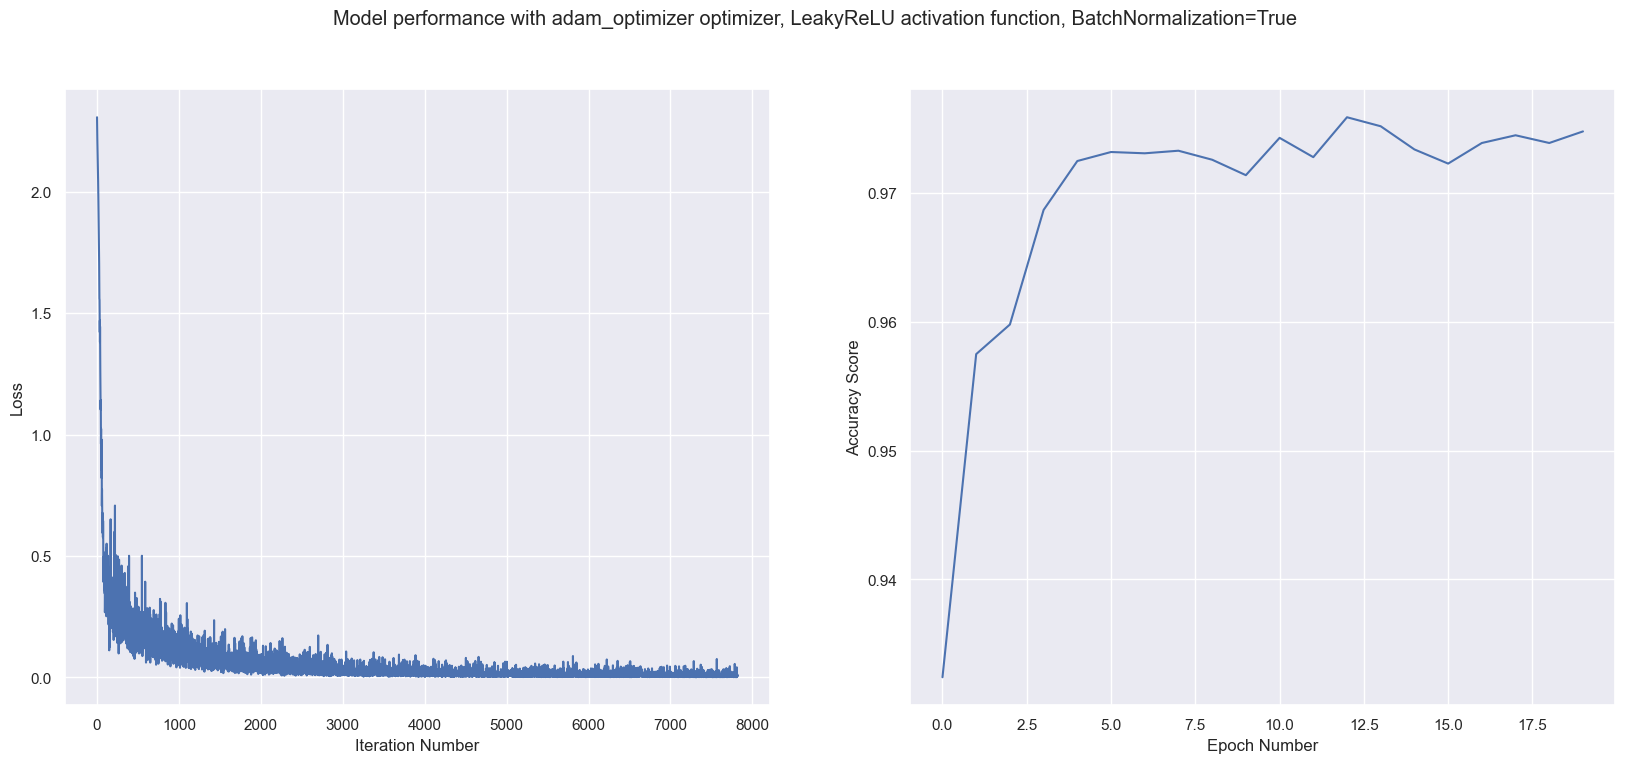

Final Loss with adam_optimizer optimizer, LeakyReLU activation function, BatchNorm=True: 0.0064
Final Accuracy with adam_optimizer optimizer, LeakyReLU activation function, BatchNorm=True: 0.9748
Training Time with adam_optimizer optimizer, LeakyReLU activation function, BatchNorm=True: 175.93 seconds



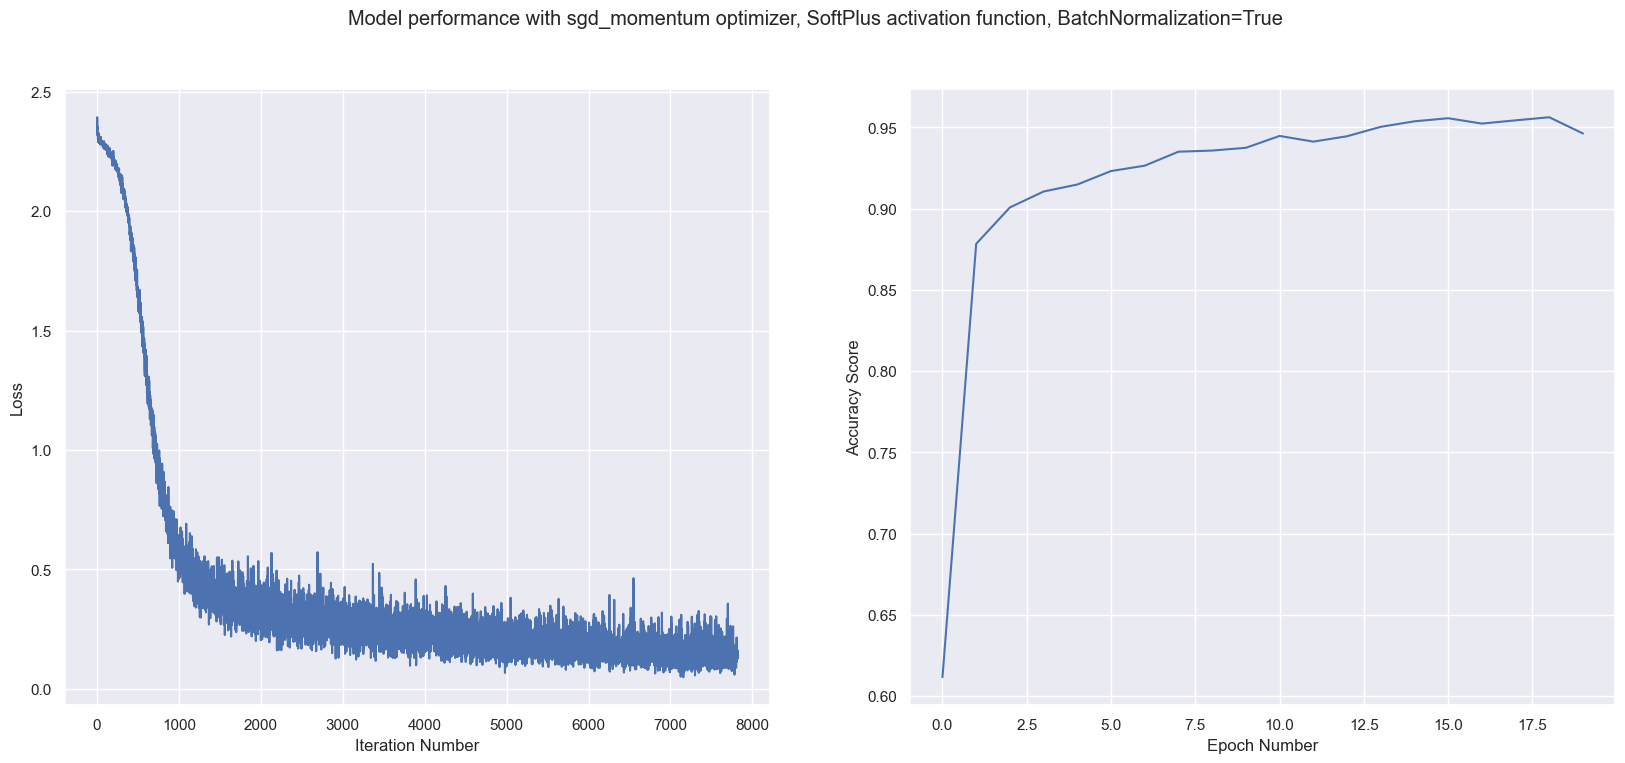

Final Loss with sgd_momentum optimizer, SoftPlus activation function, BatchNorm=True: 0.1610
Final Accuracy with sgd_momentum optimizer, SoftPlus activation function, BatchNorm=True: 0.9462
Training Time with sgd_momentum optimizer, SoftPlus activation function, BatchNorm=True: 175.93 seconds



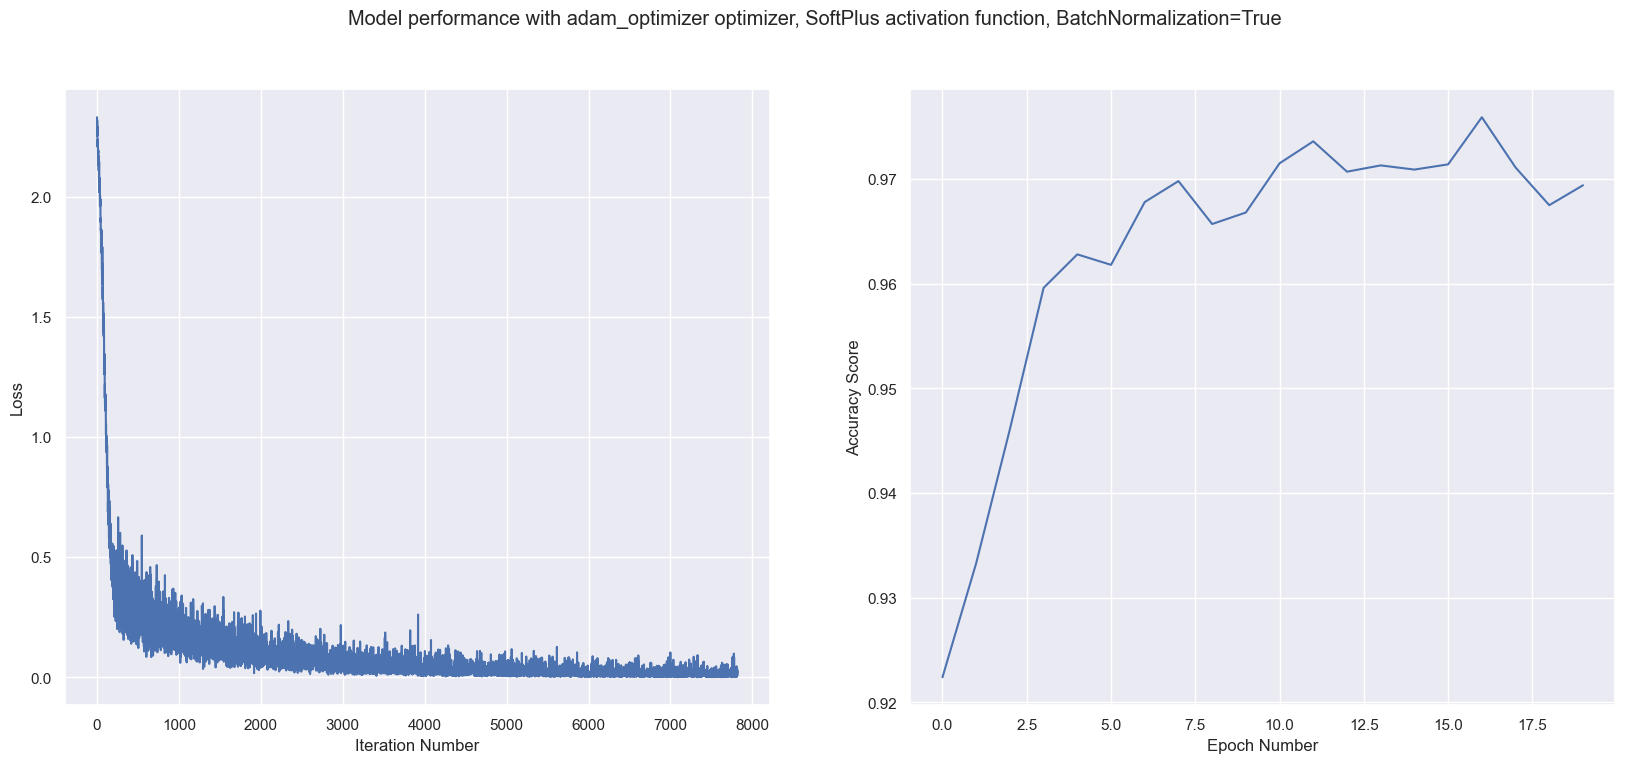

Final Loss with adam_optimizer optimizer, SoftPlus activation function, BatchNorm=True: 0.0249
Final Accuracy with adam_optimizer optimizer, SoftPlus activation function, BatchNorm=True: 0.9694
Training Time with adam_optimizer optimizer, SoftPlus activation function, BatchNorm=True: 175.93 seconds



In [677]:
for result in results:
    
    batch_normalization_parameter = result['batch_normalization_parameter']
    activation_function = result['activation_function']
    optimizer = result['optimizer']
    loss_history = result['loss_history']
    accuracy_history = result['accuracy_history']

    final_loss = loss_history[-1]
    final_accuracy = accuracy_history[-1]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    plt.suptitle(f'Model performance with {optimizer} optimizer, {activation_function} activation function, BatchNormalization={batch_normalization_parameter}')
            
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.xlabel("Iteration Number")
    plt.ylabel("Loss")

                    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history)
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy Score")

    plt.show()

    print(f'Final Loss with {optimizer} optimizer, {activation_function} activation function, BatchNorm={batch_normalization_parameter}: {final_loss:.4f}')
    print(f'Final Accuracy with {optimizer} optimizer, {activation_function} activation function, BatchNorm={batch_normalization_parameter}: {final_accuracy:.4f}')
    print(f'Training Time with {optimizer} optimizer, {activation_function} activation function, BatchNorm={batch_normalization_parameter}: {training_time:.2f} seconds\n')

Исходя из полученной acccuracy и поведения графиков, наиболее подходящей функцией активации мне показалась именно ELU, поэтому в дальнейшем будем использовать ее.

In [678]:
results_elu = [result for result in results if result['activation_function'] == 'ELU']

In [679]:
for result in results_elu:
    batch_normalization_parameter = result['batch_normalization_parameter']
    activation_function = result['activation_function']
    optimizer = result['optimizer']
    loss_history = result['loss_history']
    accuracy_history = result['accuracy_history']

    final_loss = loss_history[-1]
    final_accuracy = accuracy_history[-1]
    
    print(f'Final Loss with {optimizer} optimizer, {activation_function} activation function, BatchNorm={batch_normalization_parameter}: {final_loss:.4f}')
    print(f'Final Accuracy with {optimizer} optimizer, {activation_function} activation function, BatchNorm={batch_normalization_parameter}: {final_accuracy:.4f}\n')
   

Final Loss with sgd_momentum optimizer, ELU activation function, BatchNorm=False: 0.1302
Final Accuracy with sgd_momentum optimizer, ELU activation function, BatchNorm=False: 0.9435

Final Loss with adam_optimizer optimizer, ELU activation function, BatchNorm=False: 0.0059
Final Accuracy with adam_optimizer optimizer, ELU activation function, BatchNorm=False: 0.9781

Final Loss with sgd_momentum optimizer, ELU activation function, BatchNorm=True: 0.1591
Final Accuracy with sgd_momentum optimizer, ELU activation function, BatchNorm=True: 0.9573

Final Loss with adam_optimizer optimizer, ELU activation function, BatchNorm=True: 0.0177
Final Accuracy with adam_optimizer optimizer, ELU activation function, BatchNorm=True: 0.9677



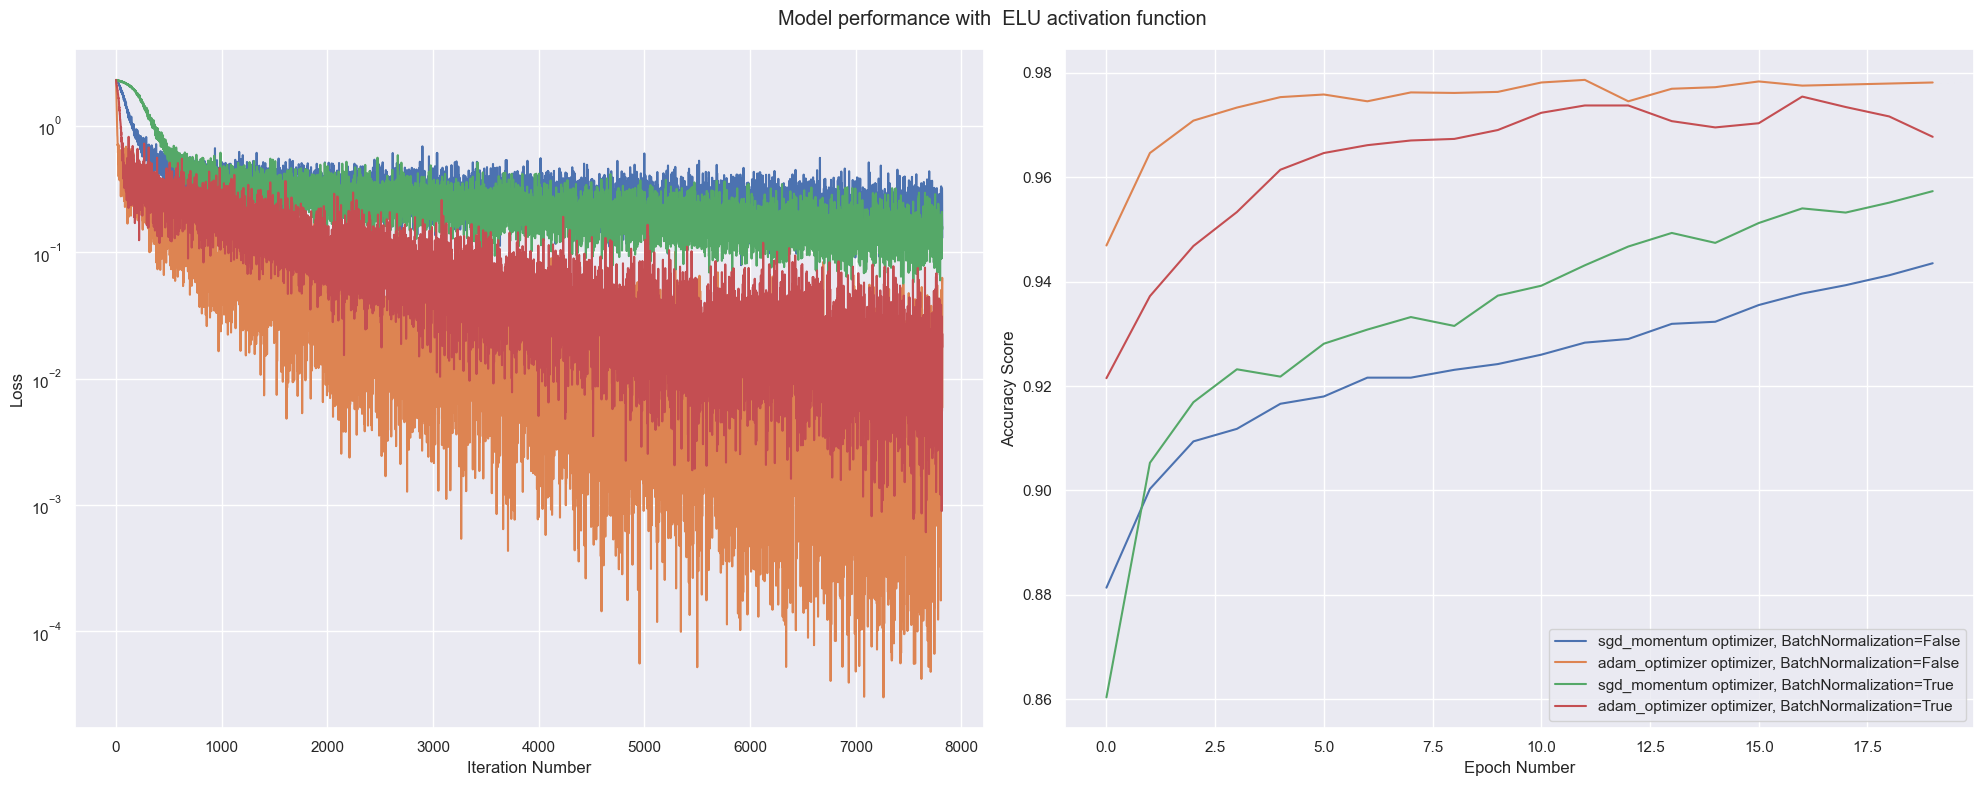

In [680]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.suptitle(f'Model performance with  ELU activation function')


for result in results_elu:
    
    batch_normalization_parameter = result['batch_normalization_parameter']
    optimizer = result['optimizer']
    loss_history = result['loss_history']
    accuracy_history = result['accuracy_history']
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label=f'{optimizer} optimizer, BatchNormalization={batch_normalization_parameter}')

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label=f'{optimizer} optimizer, BatchNormalization={batch_normalization_parameter}')

plt.subplot(1, 2, 1)
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy Score")

plt.legend()
plt.tight_layout()

plt.show()

Из графиков видно, что сеть, обученная с помощью momentum_sgd как в случае c BatchNormalize=False, так и c BatchNormalize=True показывает себя лучше с точки зрения loss (он ближе к 0.5), но хуже с точки зрения accuracy по сравнению с adam. Причем, стоит отметить тот факт, что в случае с momentum_sgd BatchNormalization увеличивает accuracy , а с adam - наоборот ухудшает. Loss же в любом случае стабилизируется после применения BatchNormalization.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Выше уже было написано, что ELU показало себя лучше всего по сравнению с другмими функциями активации c точки зрения loss и accuracy одновременно, а так же описаны последствия применения BatchNormalization. Время работы же оказалось одинаковым вне завимости от выбранных гиперпараметров модели.
Еще предположу, что преимущество в accuracy модели существеннее, чем стабильность loss, поэтому в дальнейшем будем использовать модель со следующими гиперпараметрами: activation_function=ELU, optimizer=adam_optimizer, BatchNormalization=False.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [927]:
# Your code goes here. ################################################
net = Sequential()
net.add(Linear(784, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ELU())
net.add(Dropout(0.5)) 
net.add(Linear(128, 10))
net.add(LogSoftMax())

n_epoch = 20
batch_size = 128

criterion = ClassNLLCriterion()

batch_normalization_parameters = False
activation_function = ELU
optimizer = adam_optimizer

optimizer_config = {'learning_rate' : 3e-3, 'momentum': 0.9, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5}
optimizer_state = {}

loss_history = []
accuracy_history = []

In [685]:
def update_optimizer_config(optimizer_config, epoch):
    if epoch % 10 == 0:
        optimizer_config['learning_rate'] *= 0.5
    return optimizer_config

In [686]:
start_time = time.time()

for epoch in range(n_epoch):
    net.train()

    optimizer_config = update_optimizer_config(optimizer_config, epoch)

    for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size), position=0, leave=False):

        net.zeroGradParameters()

        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        optimizer(net.getParameters(),
                    net.getGradParameters(),
                    optimizer_config,
                    optimizer_state)

        loss_history.append(loss)

    net.evaluate()
    accuracy = accuracy_score(net.forward(X_val).argmax(axis=-1), y_val)
    accuracy_history.append(accuracy)

end_time = time.time()
training_time = end_time - start_time

Epoch 20/20, Loss: 0.0773, Accuracy: 0.9715


In [ ]:
print(f'Loss on val set: {loss[-1]:.4f}, Accuracy on val set: {accuracy[-1]:.4f}')

Print here your accuracy on test set. It should be around 90%.

In [697]:
# Your answer goes here. ################################################
net.evaluate()
accuracy = accuracy_score(net.forward(X_test).argmax(axis=-1), y_test)
print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.9711


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [980]:
# Your beautiful code here.
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)

X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

In [981]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(784, 128)
        self.batch_norm = nn.BatchNorm1d(128)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.linear1(x)
        x = self.elu(x)
        x = self.dropout(x)
        x = self.batch_norm(x)
        x = self.linear2(x)
        return x

In [982]:
net = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-3,  betas=(0.99, 0.99), eps=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10)

n_epoch = 20
batch_size = 128

In [983]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [984]:
for epoch in range(n_epoch):
    net.train()
    for x_batch, y_batch in tqdm(train_loader, position=0, leave=False):
        
        predictions = net(x_batch)
        loss = criterion(predictions, y_batch)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()

In [989]:
predicted_labels_val = []
real_labels_val = []
net.eval()

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        predictions = net(x_batch.view(-1, 784))
        predicted_labels_val.append(predictions.argmax(dim=1))
        real_labels_val.append(y_batch)

predicted_labels_val = torch.cat(predicted_labels_val)
real_labels_val = torch.cat(real_labels_val)
val_acc = (predicted_labels_val == real_labels_val).type(torch.FloatTensor).mean()

In [990]:
print(f'Neural network accuracy on val set: {val_acc:3.5}')

Neural network accuracy on val set: 0.9768


In [991]:
predicted_labels_test = []
real_labels_test = []
net.eval()

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = net(x_batch.view(-1, 784))
        predicted_labels_test.append(predictions.argmax(dim=1))
        real_labels_test.append(y_batch)

predicted_labels_test = torch.cat(predicted_labels_test)
real_labels_test = torch.cat(real_labels_test)
test_acc = (predicted_labels_test == real_labels_test).type(torch.FloatTensor).mean()

In [992]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9762


Как видно, получилось достигнуть результата даже лучшего, чем в написанной нами нейросети, а время работы при этом без преувеличений скоратилось в ~10 раз.